# Predicting Potential Customers For an Insurance Policy - CoIL 2000 Challenge - Machine Learning

Now we are ready for machine learning. We will start from logistic regression and then we will go to neural networks. 

In [2]:
# read the feature description txt. file and make a list of feature names
features_list = [] 
fh = open('TicDataDescr.txt', 'r')
for i, line in enumerate(fh):
    if 32 < i < 51: # 204:
        features_list.append(line.rstrip('\n')[2:])
    elif 51 <= i< 204:
        features_list.append(line.rstrip('\n')[3:])
fh.close()

while '' in features_list:
    features_list.remove('')
#print(features_list)
#len(features_list)

In [3]:
import pandas as pd
df = pd.read_table('ticdata2000.txt', names=features_list) # assign the feature names from the list prepared before
#df_test = pd.read_table('ticeval2000.txt', names=features_list) # test data set

In [4]:
# Find the total number of positive class in the target - baseline
ls = list(df['CARAVAN Number of mobile home policies 0 - 1'].values)
num_policy_users = ls.count(1)
num_nonusers = ls.count(0)
users_perc = num_policy_users*100/(num_policy_users+num_nonusers)
print(num_policy_users, users_perc)

348 5.977327378907592


We have a baseline for our models here, 348 out of 5822 customers, which is about 6%, own the insurence policy. This means only 6% of the total customers belong to the positive class and hence the data is unbalanced.

In [7]:
# Modeling - Logistic Regression
import numpy as np
X = df.drop('CARAVAN Number of mobile home policies 0 - 1',axis = 1) #feature
X['MOSTYPE Customer Subtype see L0']  = np.log(1+X['MOSTYPE Customer Subtype see L0'].values) # rescale this column
y = df['CARAVAN Number of mobile home policies 0 - 1'] #target
#X_testset = df_test.drop('CARAVAN Number of mobile home policies 0 - 1',axis = 1)
#X_testset['MOSTYPE Customer Subtype see L0'] = np.log(1+X_testset['MOSTYPE Customer Subtype see L0'].values)
#y_testset = df_test['CARAVAN Number of mobile home policies 0 - 1']
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)
logreg = LogisticRegression() # instantiate the model
logreg.fit(X_train,y_train) # fit the data
y_pred = logreg.predict(X_test) 
#X['MOSTYPE Customer Subtype see L0']

C:\Users\sabin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [8]:
# Model evaluation by confusion matrix
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[1356,    5],
       [  93,    2]], dtype=int64)

In [9]:
# model evaluation by accuracy, precission and Recall
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9326923076923077
Precision: 0.2857142857142857
Recall: 0.021052631578947368


The accuracy is good, precision is low, and the recall is even lower.

In [10]:
# accuracy = tp+tn/tp+tn + fp+fn (tn, fp, fn, tp)
# precision = tp/tp+fp - if predicted to be positive, what is the prob that it is true?
# recall = tp/tp+fn -  out of total positive cases, how many are predicted as positive? also known
# as true positive rate. Look for true negative rate too.
#a b// c, d sencitivity = d/c+d,  tp/tp+fn , specificity = a/a+b, tn/tn+fp

 Since it is an unbalanced data, we try Upsampling and Downsampling

In [11]:
# Upsampling
from imblearn.over_sampling import SMOTE

In [18]:
print(y_train.value_counts()) # count the numbers of 0 and 1 before sampling
smt = SMOTE()
X_train1, y_train1 = smt.fit_sample(X_train, y_train)
y_train.value_counts()
print(np.bincount(y_train1)) # count the numbers of 0 and 1 after sampling

0    4113
1     253
Name: CARAVAN Number of mobile home policies 0 - 1, dtype: int64
[4113 4113]


In [19]:
logreg.fit(X_train1,y_train1) # fit the data
y_pred = logreg.predict(X_test) 
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(cnf_matrix)
y_test.value_counts()

C:\Users\sabin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[995 366]
 [ 46  49]]


0    1361
1      95
Name: CARAVAN Number of mobile home policies 0 - 1, dtype: int64

Text(0.5,15,'Predicted label')

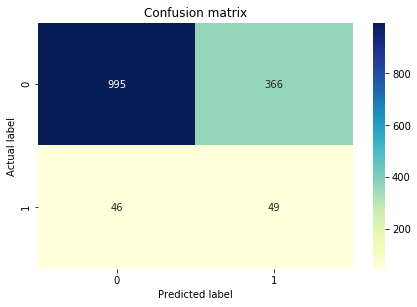

In [22]:
# Visualize the confusion matrix by using a heatmap
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [20]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.717032967032967
Precision: 0.1180722891566265
Recall: 0.5157894736842106


The accuracy is around 70% which is reasonable. To understand how good are the values of precision and recall, 
the precision of 0.12 means that if an observation is predicted to be positive, there is 12% chance that it is actually positive.
Compared to our base value (which is 6% from a random guess), its a significant improvement. Similarly, the value of recall is 0.52
meaning that out of all positve class cases 52% were identified as positive. 

In [23]:
# Now, do down sampling applying NearMiss
from imblearn.under_sampling import NearMiss
nr = NearMiss()
X_train2, y_train2 = nr.fit_sample(X_train, y_train)
np.bincount(y_train2)

logreg.fit(X_train2, y_train2) # fit the data
y_pred = logreg.predict(X_test) 
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(cnf_matrix)

[[450 911]
 [ 30  65]]


C:\Users\sabin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [24]:
# model evaluation by accuracy, precission and Recall
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.35370879120879123
Precision: 0.06659836065573771
Recall: 0.6842105263157895


Better than before in recall but worse in accuracy and precision

In [26]:
## Neural network in Keras
import numpy as np
from keras.layers import Dense
from keras.models import Sequential
n_cols = df.shape[1]-1
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from time import time
# create baseline model
def create_baseline(optimizer='rmsprop', init = 'uniform'):
    model = Sequential()
    model.add(Dense(85, activation='relu', input_dim=n_cols))
    model.add(Dense(85, activation='relu'))
    model.add(Dense(85, activation='relu'))
    model.add(Dense(85, activation='relu'))
    model.add(Dense(85, activation='relu'))
    model.add(Dense(1, activation='sigmoid')) 
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy']) 
    return model


In [38]:
# Hyperparameter tuning by GridsearchCV
start = time()
model = KerasClassifier(build_fn=create_baseline, verbose = 0)

inits = ['glorot_uniform', 'normal']
optimizers = ['rmsprop', 'adam']
epochs = np.array([60])
batches = np.array([10])

param_dict = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, init=inits)
grid = GridSearchCV(estimator=model, param_grid=param_dict)
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#for params, mean_score, scores in grid_result.grid_scores_:
#    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))
print("total time:",time()-start)
best_epochs = grid_result.best_params_['epochs']
best_batch_size = grid_result.best_params_['batch_size']
best_init = grid_result.best_params_['init']
best_optimizer = grid_result.best_params_['optimizer']

C:\Users\sabin\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best: 0.942052 using {'batch_size': 10, 'epochs': 60, 'init': 'glorot_uniform', 'optimizer': 'rmsprop'}
total time: 960.1043825149536


GridsearchCV is very slow, so we tune the hyperparameters manually.

In [27]:
# do it manually
best_epochs = 60
best_batch_size = 10
best_init = 'glorot_uniform'
best_optimizer = 'adam'
# Now create a classifier with manually chosen parameters
classifier_pred = KerasClassifier(build_fn=create_baseline, optimizer=best_optimizer, init=best_init, epochs=best_epochs, batch_size=best_batch_size, verbose=1)
classifier_pred.fit(X_train, y_train)

Epoch 1/60
4366/4366 [==============================] - 3s 744us/step - loss: 0.2209 - acc: 0.9418
Epoch 2/60
4366/4366 [==============================] - 2s 430us/step - loss: 0.2060 - acc: 0.9421
Epoch 3/60
4366/4366 [==============================] - 2s 426us/step - loss: 0.1987 - acc: 0.9421
Epoch 4/60
4366/4366 [==============================] - 2s 419us/step - loss: 0.1952 - acc: 0.9421
Epoch 5/60
4366/4366 [==============================] - 2s 423us/step - loss: 0.1933 - acc: 0.9421
Epoch 6/60
4366/4366 [==============================] - 2s 417us/step - loss: 0.1903 - acc: 0.9421
Epoch 7/60
4366/4366 [==============================] - 2s 420us/step - loss: 0.1832 - acc: 0.9421
Epoch 8/60
4366/4366 [==============================] - 2s 420us/step - loss: 0.1847 - acc: 0.9421
Epoch 9/60
4366/4366 [==============================] - 2s 429us/step - loss: 0.1780 - acc: 0.9423
Epoch 10/60
4366/4366 [==============================] - 2s 421us/step - loss: 0.1753 - acc: 0.9425
Epoch 11/

In [42]:
y_pred=classifier_pred.predict(X_test)
## calculate model performance
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

1456/1456 [==============================] - 0s 135us/step
[[1304   57]
 [  88    7]]
Accuracy: 0.9004120879120879
Precision: 0.109375
Recall: 0.07368421052631578


Logistic regression with upsampling is the best model so far. Now we try other classifiers as well.

In [28]:
# Other classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classifiers = [GaussianNB(var_smoothing=1e-04), MultinomialNB(alpha=1, class_prior=None, fit_prior=True),
               RandomForestClassifier(max_depth=6, criterion = 'gini', max_features = 'log2', n_estimators=20),AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.8, n_estimators=50, random_state=None), GradientBoostingClassifier(),
               KNeighborsClassifier(5), SVC(kernel="rbf", C=0.25, probability=True), DecisionTreeClassifier(),
              LinearDiscriminantAnalysis(),QuadraticDiscriminantAnalysis(tol=0.1e-6, reg_param=0.1)]

In [193]:
for model in classifiers:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = metrics.confusion_matrix(y_test, y_pred)
    print(model)
    print(cm)
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("Precision:",metrics.precision_score(y_test, y_pred))
    print("Recall:",metrics.recall_score(y_test, y_pred))

GaussianNB(priors=None, var_smoothing=0.0001)
[[885 476]
 [ 32  63]]
Accuracy: 0.6510989010989011
Precision: 0.11688311688311688
Recall: 0.6631578947368421
MultinomialNB(alpha=1, class_prior=None, fit_prior=True)
[[1103  258]
 [  53   42]]
Accuracy: 0.7864010989010989
Precision: 0.14
Recall: 0.4421052631578947
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
[[1361    0]
 [  95    0]]
Accuracy: 0.9347527472527473
Precision: 0.0
Recall: 0.0


C:\Users\sabin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.8, n_estimators=50, random_state=None)
[[1341   20]
 [  87    8]]
Accuracy: 0.926510989010989
Precision: 0.2857142857142857
Recall: 0.08421052631578947
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
[[1351   10]
 [  94    1]]
Accuracy: 0.9285714285714286
Precision: 0.09090909090909091
Recall: 0.010526315789473684
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=No

C:\Users\sabin\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=0.25, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
[[1361    0]
 [  95    0]]
Accuracy: 0.9347527472527473
Precision: 0.0
Recall: 0.0
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
[[1279   82]
 [  82   13]]
Accuracy: 0.8873626373626373
Precision: 0.1368421052631579
Recall: 0.1368421052631579
LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)
[[1349   12]
 [  91    4]]
Accuracy: 0.9292582417582418
Precision: 0.25
Recall:

C:\Users\sabin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sabin\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


The hyper parameters for all the above models were tuned manually. Among the models we trained, Logistic regression, GaussianNB and MultinomialNB (neural network models) performed well. 
